In [1]:
# 載入數據集
from datasets import load_dataset
from haystack import Document

# 加載 PubMedQA 數據集，取前 1000 條數據
dataset = load_dataset(
    "vblagoje/PubMedQA_instruction",
    split="train"
)
dataset = dataset.select(range(1000))

# 提取文件
all_documents = [
    Document(content=doc["context"])
    for doc in dataset
]
# 提取問題
all_questions = [
    doc["instruction"]
    for doc in dataset
]
# 提取真實答案
all_ground_truth_answers = [
    doc["response"]
    for doc in dataset
]

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import List
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

In [3]:
# 建立索引管道
indexing = Pipeline()

In [4]:
# 建立 `文件嵌入器`
document_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2"
)

# 建立 `內存文件儲存` 對象
document_store = InMemoryDocumentStore()

# 使用儲存對象建立 `文件寫入器`
document_writer = DocumentWriter(
    document_store=document_store,
    # 重複時跳過
    policy=DuplicatePolicy.SKIP
)

In [5]:
# 添加管道元件
indexing.add_component(
    instance=document_embedder,
    name="document_embedder"
)
indexing.add_component(
    instance=document_writer,
    name="document_writer"
)

In [6]:
# 連接管道元件：連接嵌入器和寫入器
indexing.connect(
    "document_embedder.documents",
    "document_writer.documents"
)

🚅 Components
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - document_embedder.documents -> document_writer.documents (List[Document])

In [7]:
# 執行索引管道
indexing.run(
    {"document_embedder": {"documents": all_documents}}
)

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


{'document_writer': {'documents_written': 1000}}

In [8]:
indexing.draw('ex15-1.png')

In [9]:
import os
from getpass import getpass
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
# 設置 OpenAI API 金鑰
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [10]:
from haystack.components.builders import AnswerBuilder, PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

In [11]:
# 定義生成答案的模板
template = """
        您必須僅根據給定的上下文資訊回答以下問題。

        上下文:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        問題: {{question}}
        答案:
        """

In [12]:
# 建立 RAG 管道
rag_pipeline = Pipeline()

In [13]:
rag_pipeline.add_component(
    "query_embedder", 
    SentenceTransformersTextEmbedder(
        model="sentence-transformers/all-MiniLM-L6-v2"
    )
)
rag_pipeline.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store, top_k=3)
)
rag_pipeline.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)
rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(model="gpt-4-turbo")
)
rag_pipeline.add_component(
    "answer_builder",
    AnswerBuilder()
)

In [14]:
# 連接管道的組件
rag_pipeline.connect(
    "query_embedder", "retriever.query_embedding"
)
rag_pipeline.connect(
    "retriever", "prompt_builder.documents"
)
rag_pipeline.connect(
    "prompt_builder", "generator"
)
rag_pipeline.connect(
    "generator.replies", "answer_builder.replies"
)
rag_pipeline.connect(
    "generator.meta", "answer_builder.meta"
)
rag_pipeline.connect(
    "retriever", "answer_builder.documents"
)

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])
  - generator.meta -> answer_builder.meta (List[Dict[str, Any]])

In [17]:
# 問題：小兒肝移植術後早期降鈣素原高是否表示術後效果不佳？
question = "Do high levels of procalcitonin in the early phase after?"

# 運行管道
response = rag_pipeline.run(
    {
        "query_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question}
    }
)
# 輸出
print(response["answer_builder"]["answers"][0].data)

Batches: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


pediatric liver transplantation correlate with higher morbidity and complications? Yes, high levels of procalcitonin (PCT) on postoperative day 2 are associated with higher International Normalized Ratio values on postoperative day 5, more frequent cases of primary graft non-function, longer stays in the pediatric intensive care unit, and longer durations on mechanical ventilation. This suggests that elevated PCT levels can indeed be an indicator of higher morbidity and complications in the early phase after pediatric liver transplantation.


In [27]:
# 建立 RAG 管道
new_rag_pipeline = Pipeline()

In [28]:
# 改用支持多語言的嵌入模型
new_rag_pipeline.add_component(
    # 這是新的嵌入模型名稱
    "multi_language_embedder",
    SentenceTransformersTextEmbedder(
        # 使用新的嵌入模型
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    )
)
# 其餘組件設定維持不便
new_rag_pipeline.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(document_store, top_k=3)
)
new_rag_pipeline.add_component(
    "prompt_builder",
    PromptBuilder(template=template)
)
new_rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(model="gpt-4-turbo")
)
new_rag_pipeline.add_component(
    "answer_builder",
    AnswerBuilder()
)

In [29]:
# 連接管道的組件
new_rag_pipeline.connect(
    "multi_language_embedder", "retriever.query_embedding"
)
new_rag_pipeline.connect(
    "retriever", "prompt_builder.documents"
)
new_rag_pipeline.connect(
    "prompt_builder", "generator"
)
new_rag_pipeline.connect(
    "generator.replies", "answer_builder.replies"
)
new_rag_pipeline.connect(
    "generator.meta", "answer_builder.meta"
)
new_rag_pipeline.connect(
    "retriever", "answer_builder.documents"
)

🚅 Components
  - multi_language_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - multi_language_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])
  - generator.meta -> answer_builder.meta (List[Dict[str, Any]])

In [35]:
new_rag_pipeline.draw('new_rag_pipeline.png')

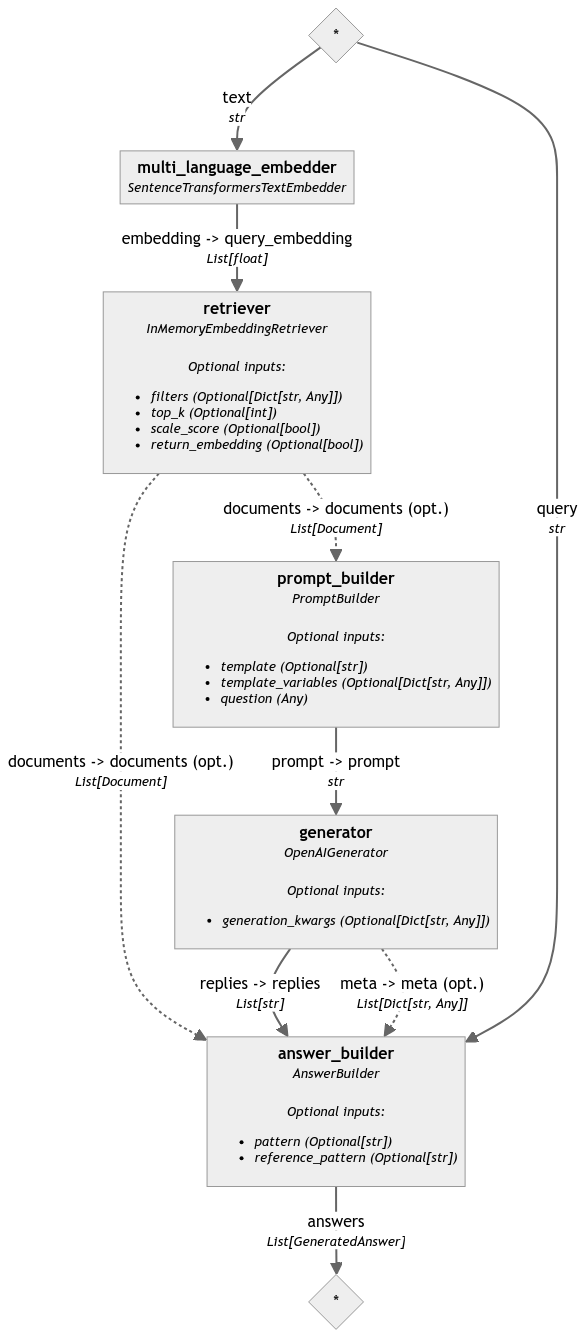

In [64]:
from utils.draw_pipeline import draw_and_display

draw_and_display(new_rag_pipeline, 'new_rag_pipeline.png')

In [33]:
# 問題
question = "小兒肝移植術後早期降鈣素原高是否表示術後效果不佳？"

# 運行管道
response = new_rag_pipeline.run(
    {
        # 使用新的嵌入模型 `multi_language_embedder`
        "multi_language_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question}
    }
)
# 輸出
print(response["answer_builder"]["answers"][0].data)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


是的，小兒肝移植術後早期降鈣素原(PCT)水平的升高與術後效果不佳有關。在上述的研究中，顯示術後第二天PCT水平高的患者在術後第五天有更高的國際標準化比率值，更常出現原發性移植物無功能的情況，並且在兒科重症監護病房停留時間更長，以及需要更長時間的機械通氣。这些結果說明PCT水平的升高與術後效果不佳有關，尤其是在肝功能及病人恢復方面。
